# QUESTION 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
from google.colab import files

In [ ]:
file = files.upload()
zip_path = "/content/archive (1).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")
print("File unzipped successfully!")

File unzipped successfully!


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('/content/dataset/Data', transform=transform)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Scratch Model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

epochs = 10
learning_rate = 0.001
Loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Scratch Model")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = Loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Scratch Model
Epoch 1, Loss: 1.1330
Epoch 2, Loss: 0.7850
Epoch 3, Loss: 0.6625
Epoch 4, Loss: 0.5645
Epoch 5, Loss: 0.4883
Epoch 6, Loss: 0.3899
Epoch 7, Loss: 0.3097
Epoch 8, Loss: 0.2245
Epoch 9, Loss: 0.2080
Epoch 10, Loss: 0.1818


In [ ]:
print("Fine-Tuned Model")

model_finetune = models.resnet18(pretrained=True)
model_finetune.fc = nn.Linear(model_finetune.fc.in_features, 4)
model_finetune = model_finetune.to(device)

# Fine tune
for param in model_finetune.parameters():
    param.requires_grad = True

optimizer_finetune = optim.Adam(model_finetune.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model_finetune.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_finetune.zero_grad()
        outputs = model_finetune(inputs)
        loss = Loss_fn(outputs, labels)
        loss.backward()
        optimizer_finetune.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Fine-Tuned Model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Epoch 1, Loss: 0.5773
Epoch 2, Loss: 0.2415
Epoch 3, Loss: 0.1739
Epoch 4, Loss: 0.2021
Epoch 5, Loss: 0.1144
Epoch 6, Loss: 0.0778
Epoch 7, Loss: 0.0976
Epoch 8, Loss: 0.1221
Epoch 9, Loss: 0.0719
Epoch 10, Loss: 0.0440


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    return classification_report(all_labels, all_preds, target_names=['Normal', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor'])

print("Model from Scratch")
report_scratch = evaluate_model(model, test_loader)
print(report_scratch)

print("Fine-Tuned Model")
report_finetune = evaluate_model(model_finetune, test_loader)
print(report_finetune)

Model from Scratch
                  precision    recall  f1-score   support

          Normal       0.89      0.82      0.85       274
    Glioma Tumor       0.89      0.73      0.80       273
Meningioma Tumor       0.84      0.94      0.89       137
 Pituitary Tumor       0.80      0.98      0.88       245

        accuracy                           0.85       929
       macro avg       0.86      0.87      0.86       929
    weighted avg       0.86      0.85      0.85       929

Fine-Tuned Model
                  precision    recall  f1-score   support

          Normal       1.00      0.79      0.88       274
    Glioma Tumor       0.86      0.94      0.90       273
Meningioma Tumor       0.96      0.94      0.95       137
 Pituitary Tumor       0.87      1.00      0.93       245

        accuracy                           0.91       929
       macro avg       0.92      0.92      0.91       929
    weighted avg       0.92      0.91      0.91       929



# QUESTION 2

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

dataset = pd.read_csv('AMZN.csv')
close = dataset['Close'].values

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

#Preprocess
lookback = 10
X, y = create_sequences(close, lookback)
print(X.shape, y.shape)


(6506, 10) (6506,)


In [ ]:
# Scale
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1))

print(X_scaled.shape, y_scaled.shape)


(6506, 10) (6506, 1)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [ ]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

#Model
model = LSTMModel(input_size=1, hidden_size=50, num_layers=1, output_size=1)
loss_function = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Batch
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Train the model
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        output = model(batch_X.unsqueeze(-1))
        loss = loss_function(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([42, 1])) that is different to the input size (torch.Size([42])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/200, Loss: 0.002256580720019402
Epoch 20/200, Loss: 0.0017312898170124683
Epoch 30/200, Loss: 0.0014391412222421734
Epoch 40/200, Loss: 0.001841312634166802
Epoch 50/200, Loss: 0.0012254984480007663
Epoch 60/200, Loss: 0.0009455670407038162
Epoch 70/200, Loss: 0.0006145311426857738
Epoch 80/200, Loss: 0.0009698938411755828
Epoch 90/200, Loss: 0.0008017978336448662
Epoch 100/200, Loss: 0.0008012793532498999
Epoch 110/200, Loss: 0.001031515779490577
Epoch 120/200, Loss: 0.0008233870830312584
Epoch 130/200, Loss: 0.0007384225629752394
Epoch 140/200, Loss: 0.0007429279952464408
Epoch 150/200, Loss: 0.0006612651105117448
Epoch 160/200, Loss: 0.0007882019914683381
Epoch 170/200, Loss: 0.0007558677275059666
Epoch 180/200, Loss: 0.000686947355125553
Epoch 190/200, Loss: 0.0006828444812124506
Epoch 200/200, Loss: 0.0006988705619675124


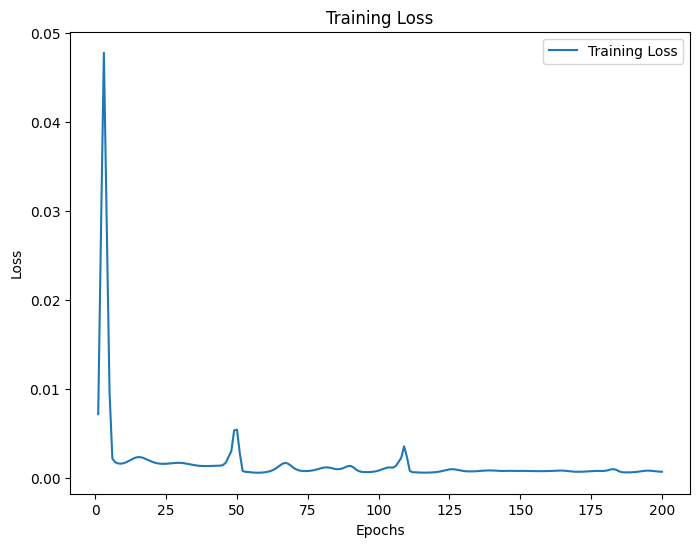

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

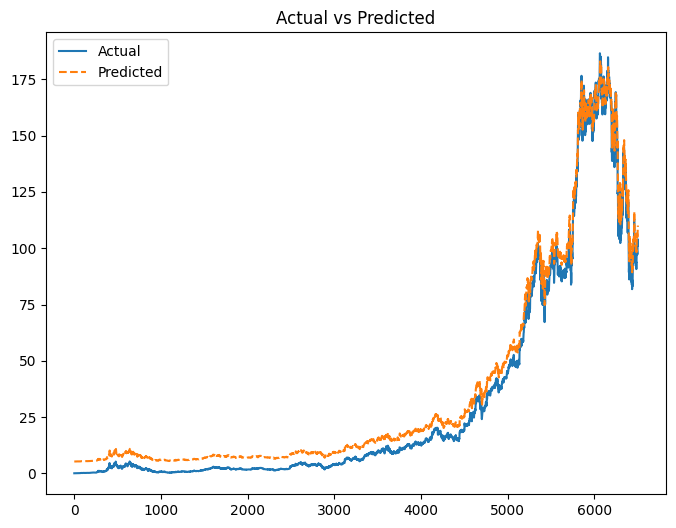

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for i in range(len(X_tensor)):
        input = X_tensor[i].unsqueeze(0).unsqueeze(-1)
        predict = model(input)
        predictions.append(predict.item())

predicted = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual = scaler.inverse_transform(y_tensor.numpy().reshape(-1, 1))

# Plot
plt.figure(figsize=(8,6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


# QUESTION 3

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
lungs = files.upload()

Saving archive (2).zip to archive (2).zip


In [ ]:
zip_path = "/content/archive (2).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/lungs")
print("File unzipped successfully!")

File unzipped successfully!


In [ ]:
df = pd.read_csv('/content/lungs/survey lung cancer.csv')

In [ ]:
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
# Encoding 'GENDER' and 'LUNG_CANCER'
#1->M 0->F
df['GENDER'] = df['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
#1->YES 0->NO
df['LUNG_CANCER'] = df['LUNG_CANCER'].apply(lambda x: 1 if x == 'YES' else 0)

In [ ]:
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


In [ ]:
# Separate features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

#70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Training shape: (216, 15), Test shape: (93, 15)


In [ ]:
svm = SVC(kernel='linear', random_state=42)

svm.fit(X_train, y_train)
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

train_report = classification_report(y_train, y_train_pred)
test_report = classification_report(y_test, y_test_pred)

print("Training Set Classification Report:\n", train_report)
print("Testing Set Classification Report:\n", test_report)

Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        32
           1       0.96      0.96      0.96       184

    accuracy                           0.93       216
   macro avg       0.85      0.85      0.85       216
weighted avg       0.93      0.93      0.93       216

Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.98      0.99      0.98        86

    accuracy                           0.97        93
   macro avg       0.91      0.85      0.88        93
weighted avg       0.97      0.97      0.97        93

